In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
from google.colab.data_table import DataTable
DataTable.max_columns = 40

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
import os

In [4]:
train_data = pd.read_csv("/content/drive/MyDrive/ml_mai/train.csv")
test_data = pd.read_csv("/content/drive/MyDrive/ml_mai/test.csv")

Удалим колонку ApplicationDate, этой информацией можно пренебречь, и еще эта колонка будет мешать в последующей обработке.

In [5]:
train_data = train_data.drop('ApplicationDate', axis = 1)
test_data = test_data.drop('ApplicationDate', axis = 1)

Смотрим наличие выбросов в целевой колонке.

<ipython-input-6-08f7fa38ba7e>:2: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


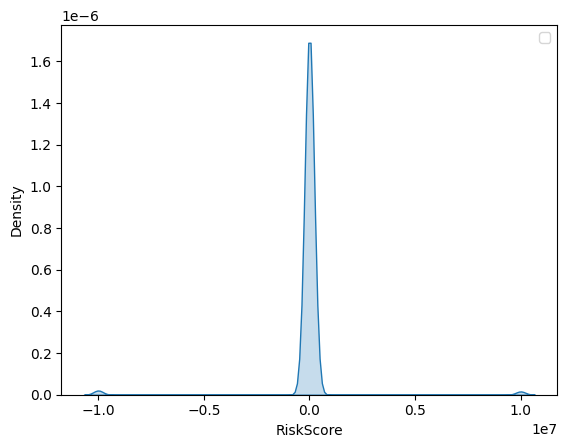

In [6]:
sns.kdeplot(train_data['RiskScore'], fill=True)
plt.legend()
plt.show()

Выбросы есть, их необходимо удалить.

In [7]:
train_data = train_data.loc[abs(train_data['RiskScore']) < 1000000]

Проверим распределение после удаления выбросов.

<Axes: xlabel='RiskScore', ylabel='Density'>

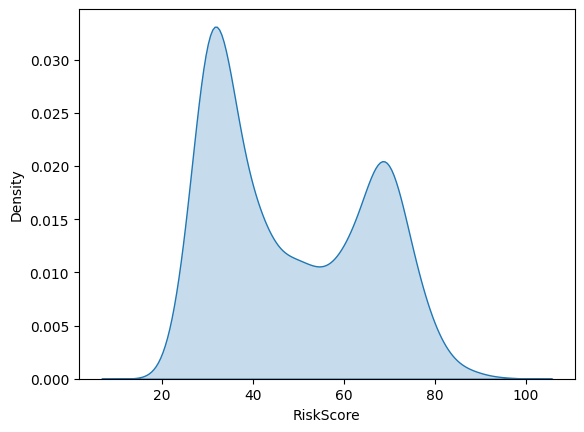

In [8]:
sns.kdeplot(train_data['RiskScore'], fill=True)

Удалим пропуски.

In [9]:
train_data = train_data.dropna()
test_data = test_data.dropna()

Разделим признаки на числовые и категориальные для дальнейшей обработки.

In [10]:
float_features = train_data.select_dtypes(include=[np.number]).columns.to_list()
float_features.remove('RiskScore')
categorical_features = train_data.select_dtypes(include=[object]).columns.to_list()

Найдем коррелирующие числовые признаки и удалим их.

In [11]:
float_df = train_data[float_features]

In [12]:
corr_matrix = float_df.corr()
float_corr_with_target = float_df.corrwith(train_data['RiskScore'])

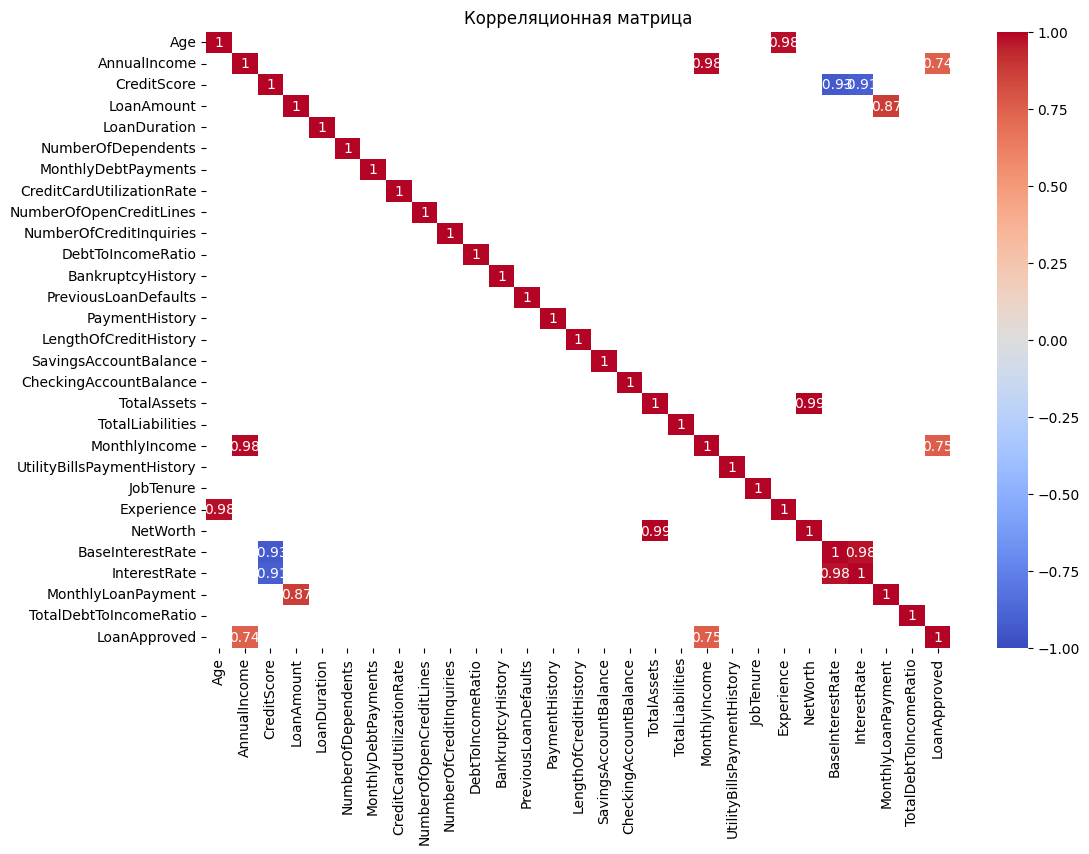

In [13]:
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix[corr_matrix.abs() >= 0.7], annot=True,  cmap="coolwarm", vmin=-1, vmax=1)
plt.title("Корреляционная матрица")
plt.show()

In [14]:
def remove_highly_correlated(features, corr_matrix, target_corr, threshold, float_df):
    selected_features = set(features)
    for i in range(len(corr_matrix.columns)):
        for j in range(i+1, len(corr_matrix.columns)):
            if corr_matrix.iloc[i,j] > threshold:
                feat_i = corr_matrix.columns[i]
                feat_j = corr_matrix.columns[j]
                if target_corr[feat_i] >= target_corr[feat_j]:
                    selected_features.discard(feat_j)
                else:
                    selected_features.discard(feat_i)
    return list(selected_features)

In [15]:
selected_numerical_cols = remove_highly_correlated(float_features, corr_matrix, float_corr_with_target, 0.7, float_df)
numerical_cols = selected_numerical_cols

Для числовых признаков выполним нормализацию, для категориальных - OneHotEncoder. Последнее, по сути, излишно, ведь пропуски были удалены ранее.

In [17]:
float_pipeline = Pipeline(
    ('scaler', StandardScaler())
)

categorical_pipeline = Pipeline(
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
)

In [18]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), float_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ]
)

In [19]:
X = train_data.drop('RiskScore', axis=1)
y = train_data['RiskScore']

In [20]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=29)

In [21]:
X_train_processed = preprocessor.fit_transform(X_train)
X_val_processed = preprocessor.fit_transform(X_val)

Обучим модель.

In [22]:
model = LinearRegression()
model.fit(X_train_processed, y_train)

LinearRegression()

Проведем валидацию.

In [23]:
val_predictions = model.predict(X_val_processed)
mse = mean_squared_error(y_val, val_predictions)
rmse = np.sqrt(mse)
print(f'RMSE on validation set: {rmse}')

RMSE on validation set: 4.350949451150892


Получим предсказание.

In [24]:
test_X = test_data.drop('ID', axis=1)
test_X_processed = preprocessor.transform(test_X)

In [25]:
test_predictions = model.predict(test_X_processed)

In [26]:
submission = pd.DataFrame({'ID': test_data['ID'], 'RiskScore': test_predictions})
submission.to_csv('submission.csv', index=False)